<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/9-unsupervised-learning-techniques/03_clustering_using_dbscan_algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Clustering Fundamental

Although most of the applications of Machine Learning today are based on supervised learning (and as a result, this is where most of the investments go to), the vast majority of the available data is unlabeled: we have the input features $X$, but we do not have the labels $y$.

In this notebook we will look at a few more unsupervised learning tasks
and algorithms:

* **Clustering**-The goal is to group similar instances together into clusters.
* **Anomaly detection**-The objective is to learn what “normal” data looks like, and then use that to detect abnormal instances.
* **Density estimation**-This is the task of estimating the probability density function (PDF) of the random process that generated the dataset.

There is no universal definition of what a cluster is: it really depends on the context,
and different algorithms will capture different kinds of clusters. 

Some algorithms look for instances centered around a particular point, called a centroid. 

Others look for continuous regions of densely packed instances: these clusters can take on any shape. 

Some algorithms are hierarchical, looking for clusters of clusters. And the list goes on.

There are two popular clustering algorithms:

* **K-Means**
* **DBSCAN**

And these are the some of their applications, such as nonlinear dimensionality
reduction, semi-supervised learning, and anomaly detection.

##Setup

In [1]:
# Common imports
import numpy as np
import os
from timeit import timeit

from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
from sklearn.datasets import load_digits
from sklearn.datasets import make_moons

from scipy.stats import norm

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib.colors import LogNorm
from matplotlib.patches import Polygon

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Let's define some ploting methods.

In [2]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [3]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

In [23]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True, show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', cmap="Paired", alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("RBF gamma={}".format(sc.gamma), fontsize=14)

##DBSCAN

Let’s take a look at DBSCAN,
another popular clustering algorithm that illustrates a very different approach based
on local density estimation. This approach allows the algorithm to identify clusters of
arbitrary shapes.

This algorithm defines clusters as continuous regions of high density. 

This algorithm works well if all the clusters are dense enough and if they are well separated
by low-density regions.

The DBSCAN class in Scikit-Learn is as simple to use as
you might expect. 

Let’s test it on the moons dataset.

In [4]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [5]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X, y)

DBSCAN(eps=0.05)

The labels of all the instances are now available in the labels_ instance variable:

In [6]:
dbscan.labels_[:20]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5,  2,  3,  0,  2,  2,  2,  4,
        2,  2,  4])

Notice that some instances have a cluster index equal to –1, which means that they
are considered as anomalies by the algorithm. 

The indices of the core instances are
available in the `core_sample_indices_` instance variable, and the core instances
themselves are available in the `components_` instance variable:

In [7]:
len(dbscan.core_sample_indices_)

808

In [8]:
dbscan.core_sample_indices_[:20]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21,
       22, 23, 24])

In [9]:
dbscan.components_[:5]

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599],
       [ 0.29248724, -0.20696309],
       [-0.02637836,  0.44766267]])

In [10]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6])

In [11]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

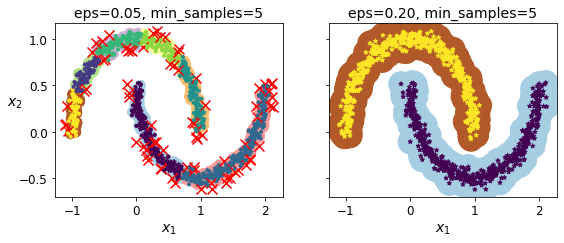

In [12]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()

As you can see, it
identified quite a lot of anomalies, plus seven different clusters. How disappointing!

Fortunately, if we widen each instance’s neighborhood by increasing eps to 0.2, we get
the clustering on the right, which looks perfect. 

Let’s continue with this model.



In [13]:
dbscan = dbscan2

Somewhat surprisingly, the DBSCAN class does not have a `predict()` method, although it has a `fit_predict()` method. In other words, it cannot predict which cluster a new instance belongs to.

This implementation decision was made because different classification
algorithms can be better for different tasks, so the authors decided to let the user choose which one to use.Moreover, it’s not hard to implement. 

For example, let’s
train a KNeighborsClassifier:

In [14]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

Now, given a few new instances, we can predict which cluster they most likely belong
to and even estimate a probability for each cluster:

In [15]:
x_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(x_new)

array([1, 0, 1, 0])

In [16]:
knn.predict_proba(x_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

Note that we only trained the classifier on the core instances, but we could also have
chosen to train it on all the instances, or all but the anomalies: this choice depends on
the final task.

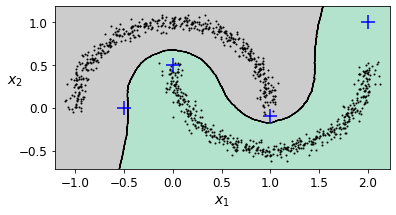

In [17]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(x_new[:, 0], x_new[:, 1], c="b", marker="+", s=200, zorder=10)

plt.show()

Notice that since there is no anomaly in the training set, the classifier
always chooses a cluster, even when that cluster is far away. It is fairly straightforward
to introduce a maximum distance, in which case the two instances that are
far away from both clusters are classified as anomalies.


To do this, use the `kneighbors()` method of the `KNeighborsClassifier`. Given a set of instances, it returns the distances and the indices of the k nearest neighbors in the training set (two matrices,
each with k columns):

In [18]:
y_dist, y_pred_idx = knn.kneighbors(x_new, n_neighbors=1)

y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] == -1
y_pred.ravel()

array([1, 0, 1, 0])

In short, `DBSCAN` is a very simple yet powerful algorithm capable of identifying any
number of clusters of any shape. It is robust to outliers, and it has just two hyperparameters
(eps and `min_samples`).

If the density varies significantly across the clusters,
however, it can be impossible for it to capture all the clusters properly. Its computational
complexity is roughly `O(m log m)`, making it pretty close to linear with regard
to the number of instances, but Scikit-Learn’s implementation can require up to
`O(m2)` memory if eps is large.

##Others Clustering Algorithms

Scikit-Learn implements several more clustering algorithms that you should take a look at.

###Agglomerative clustering

A hierarchy of clusters is built from the bottom up. Think of many tiny bubbles floating on water and gradually attaching to each other until there’s one big group of bubbles. 

Similarly, at each iteration, agglomerative clustering connects the
nearest pair of clusters (starting with individual instances). If you drew a tree with a branch for every pair of clusters that merged, you would get a binary tree
of clusters, where the leaves are the individual instances. 

This approach scales
very well to large numbers of instances or clusters. It can capture clusters of various
shapes, it produces a flexible and informative cluster tree instead of forcing
you to choose a particular cluster scale, and it can be used with any pairwise distance.

It can scale nicely to large numbers of instances if you provide a connectivity
matrix, which is a sparse m × m matrix that indicates which pairs of instances
are neighbors (e.g., returned by `sklearn.neighbors.kneighbors_graph()`).

Without a connectivity matrix, the algorithm does not scale well to large datasets.

In [25]:
X = np.array([0, 2, 5, 8.5]).reshape(-1, 1)

In [26]:
agg = AgglomerativeClustering(linkage="complete").fit(X)

In [28]:
def learned_parameters(model):
  return [m for m in dir(model) if m.endswith("_") and not m.startswith("_")]

learned_parameters(agg)

['children_',
 'labels_',
 'n_clusters_',
 'n_connected_components_',
 'n_features_in_',
 'n_leaves_']

In [29]:
agg.children_

array([[0, 1],
       [2, 3],
       [4, 5]])

In [30]:
agg.labels_

array([1, 1, 0, 0])

In [31]:
agg.n_clusters_

2

###Spectral clustering

This algorithm takes a similarity matrix between the instances and creates a lowdimensional
embedding from it (i.e., it reduces its dimensionality), then it uses another clustering algorithm in this low-dimensional space (Scikit-Learn’s implementation
uses K-Means.)

Spectral clustering can capture complex cluster structures,
and it can also be used to cut graphs (e.g., to identify clusters of friends on
a social network). It does not scale well to large numbers of instances, and it does
not behave well when the clusters have very different sizes.

In [20]:
sc1 = SpectralClustering(n_clusters=2, gamma=100, random_state=42)
sc1.fit(X)

SpectralClustering(gamma=100, n_clusters=2, random_state=42)

In [21]:
sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(X)

SpectralClustering(gamma=1, n_clusters=2, random_state=42)

In [22]:
np.percentile(sc1.affinity_matrix_, 95)

0.04251990648936265

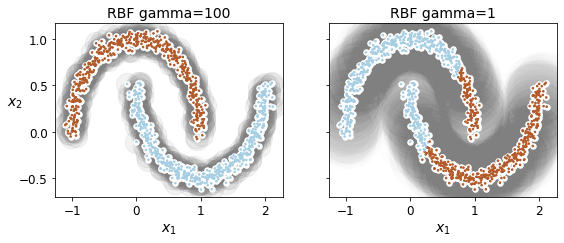

In [24]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()